# Visit individual Calexp from Selected visits

- author Sylvie Dagoret-Campagne
- creation date 2024-05-03
- last update 2024-05-03
- affiliation : IJCLab
w_2024_16



In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm


import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.io import fits
from astropy.wcs import WCS


import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle
from collections import OrderedDict

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.time import Time


In [3]:
import lsst.daf.butler as dafButler
#import lsst.summit.utils.butlerUtils as butlerUtils

In [4]:
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.afw.table as afwTable
import lsst.geom as geom

In [5]:
# LSST Display
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

In [6]:
transform = AsinhStretch() + PercentileInterval(99.)

Import statements that we will need later

Let's make a new plot and metric tool, we'll base it on the example in the getting started guide.

In [7]:
# INSERT YOUR collection and tract
# for rehearsal use collection 2 which have CCDvisit
butlerRoot = "/repo/embargo"

collection1 = 'LSSTComCamSim/runs/nightlyvalidation/20240402/d_2024_03_29/DM-43612'
collection2 = 'LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612'
collection3 = 'LSSTComCamSim/runs/nightlyvalidation/20240404/d_2024_03_29/DM-43612'
collection = 'LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985'
collectionn = collection
#collections = [collection1,collection2,collection3]
collections = [collection]
collectionStr = collectionn.replace("/", "_")
instrument = 'LATISS'
skymapName = "latiss_v1"
where_clause = "instrument = \'" + instrument+ "\'"
tract = 3864 # mostly for light-curves
#tract = 5615
# tract = 5634 # interesting to view calib parameters
suptitle = collectionStr + f" inst = {instrument} tract = {tract}"

In [8]:
#dataId = {"skymap": "latiss_v1", "tract": 5615, "instrument": "LATISS"}
dataId = {"skymap": skymapName, "tract": tract, "instrument": instrument}
repo = '/sdf/group/rubin/repo/oga/'
butler = dafButler.Butler(repo)
#t = Butler.get(table_sel, dataId=dataId, collections=collections)
registry = butler.registry

In [9]:
skymap_auxtel ='latiss_v1'
skymap = butler.get('skyMap', skymap=skymap_auxtel, collections=collections)

In [10]:
def get_corners_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    corners_ra, corners_dec in decimal degrees
    """

    corners_x = [bbox.beginX, bbox.beginX, bbox.endX, bbox.endX]
    corners_y = [bbox.beginY, bbox.endY, bbox.endY, bbox.beginY]
    corners_ra = []
    corners_dec = []
    for i in range(4):
        radec = wcs.pixelToSky(corners_x[i], corners_y[i])
        corners_ra.append(radec.getRa().asDegrees())
        corners_dec.append(radec.getDec().asDegrees())
    
    return corners_ra, corners_dec

In [11]:
def convert_fluxtomag(x) :
    """
    The object and source catalogs store only fluxes. There are hundreds of flux-related columns, 
    and to store them also as magnitudes would be redundant, and a waste of space.
    All flux units are nanojanskys. The AB Magnitudes Wikipedia page provides a concise resource 
    for users unfamiliar with AB magnitudes and jansky fluxes. To convert to AB magnitudes use:
    As demonstrated in Section 2.3.2, to add columns of magnitudes after retrieving columns of flux, users can do this:
    results_table['r_calibMag'] = -2.50 * numpy.log10(results_table['r_calibFlux']) + 31.4
    results_table['r_cModelMag'] = -2.50 * numpy.log10(results_table['r_cModelFlux']) + 31.4
    (from DP0 tutorial)
    """
    return -2.50 * np.log10(x) + 31.4

## Selected visits

In [12]:
if 0:
    file_selected_visits = "../data/202402/SelectedVisits_fall2023_tract_3864.csv"

    df_myselectedvisits = pd.read_csv(file_selected_visits,index_col=0)

    # select the band
    cut = df_myselectedvisits.band == band_sel 
    df_myselectedvisits = df_myselectedvisits[cut]

    my_selectedvisits = list(df_myselectedvisits.index)

    #move the visitid as a column not to loose it during the merge 
    df_myselectedvisits.reset_index(inplace=True) 

    index=10
    visitId = my_selectedvisits[index]

In [13]:
#df_myselectedvisits.columns

In [14]:
visitId = 2023051100278 	

In [15]:
datasetType = 'calexp'
dataId = {'visit': visitId, 'instrument':instrument , 'detector': 0}
datasetRefs = registry.queryDatasets(datasetType, dataId=dataId, collections  = collections)

for i, ref in enumerate(datasetRefs):
    print(ref.dataId)
    print("band:", ref.dataId['band'])
    band = ref.dataId['band']

{instrument: 'LATISS', detector: 0, visit: 2023051100278, band: 'g', day_obs: 20230511, physical_filter: 'SDSSg_65mm~empty'}
band: g


## Sources in Calexp

In [16]:
# Create a basic schema to use with these tasks
schema = afwTable.SourceTable.makeMinimalSchema()
print(schema)

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
)



In [17]:
tab = afwTable.SourceTable.make(schema)

In [18]:
src_cat = butler.get('src', dataId= dataId, collections=collections)

In [19]:
schema = src_cat.getSchema()
tab = afwTable.SourceTable.make(schema)

In [20]:
src_cat.asAstropy().to_pandas()

id  coord_ra  coord_dec              parent  \
0    171629665549549569  4.189301  -0.418575                   0   
1    171629665549549570  4.188531  -0.418705                   0   
2    171629665549549571  4.188011  -0.418806                   0   
3    171629665549549572  4.188580  -0.418706                   0   
4    171629665549549573  4.188086  -0.418818                   0   
..                  ...       ...        ...                 ...   
270  171629665549549839  4.188867  -0.420367  171629665549549713   
271  171629665549549840  4.189163  -0.420343  171629665549549717   
272  171629665549549841  4.189128  -0.420332  171629665549549717   
273  171629665549549842  4.188894  -0.420461  171629665549549722   
274  171629665549549843  4.188898  -0.420480  171629665549549722   

     calib_detected  calib_psf_candidate  calib_psf_used  calib_psf_reserved  \
0             False                False           False               False   
1             False                False           False               False   
2             False                False           False               False   
3             False                False           False               False   
4              True                False           False               False   
..              ...                  ...             ...                 ...   
270           False                False           False               False   
271            True                 True            True               False   
272           False                False           False               False   
273           False                False           False               False   
274           False                False           False               False   

      coord_raErr  coord_decErr  ...  slot_PsfFlux_flag_apCorr  \
0             NaN           NaN  ...                     False   
1    9.494749e-08  2.149531e-07  ...                     False   
2             NaN           NaN  ...                     False   
3             NaN           NaN  ...                     False   
4    5.802906e-08  7.071204e-08  ...                     False   
..            ...           ...  ...                       ...   
270           NaN           NaN  ...                     False   
271  4.628825e-08  4.908212e-08  ...                     False   
272  3.582601e-07  3.086973e-07  ...                     False   
273           NaN           NaN  ...                     False   
274           NaN           NaN  ...                     False   

     ext_photometryKron_KronFlux_apCorr  \
0                                   NaN   
1                                   NaN   
2                                   NaN   
3                                   NaN   
4                                   NaN   
..                                  ...   
270                                 NaN   
271                                 NaN   
272                                 NaN   
273                                 NaN   
274                                 NaN   

     ext_photometryKron_KronFlux_apCorrErr  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   
..                                     ...   
270                                    NaN   
271                                    NaN   
272                                    NaN   
273                                    NaN   
274                                    NaN   

     ext_photometryKron_KronFlux_flag_apCorr  \
0                                       True   
1                                       True   
2                                       True   
3                                       True   
4                                       True   
..                                       ...   
270                                     True

## Calexp

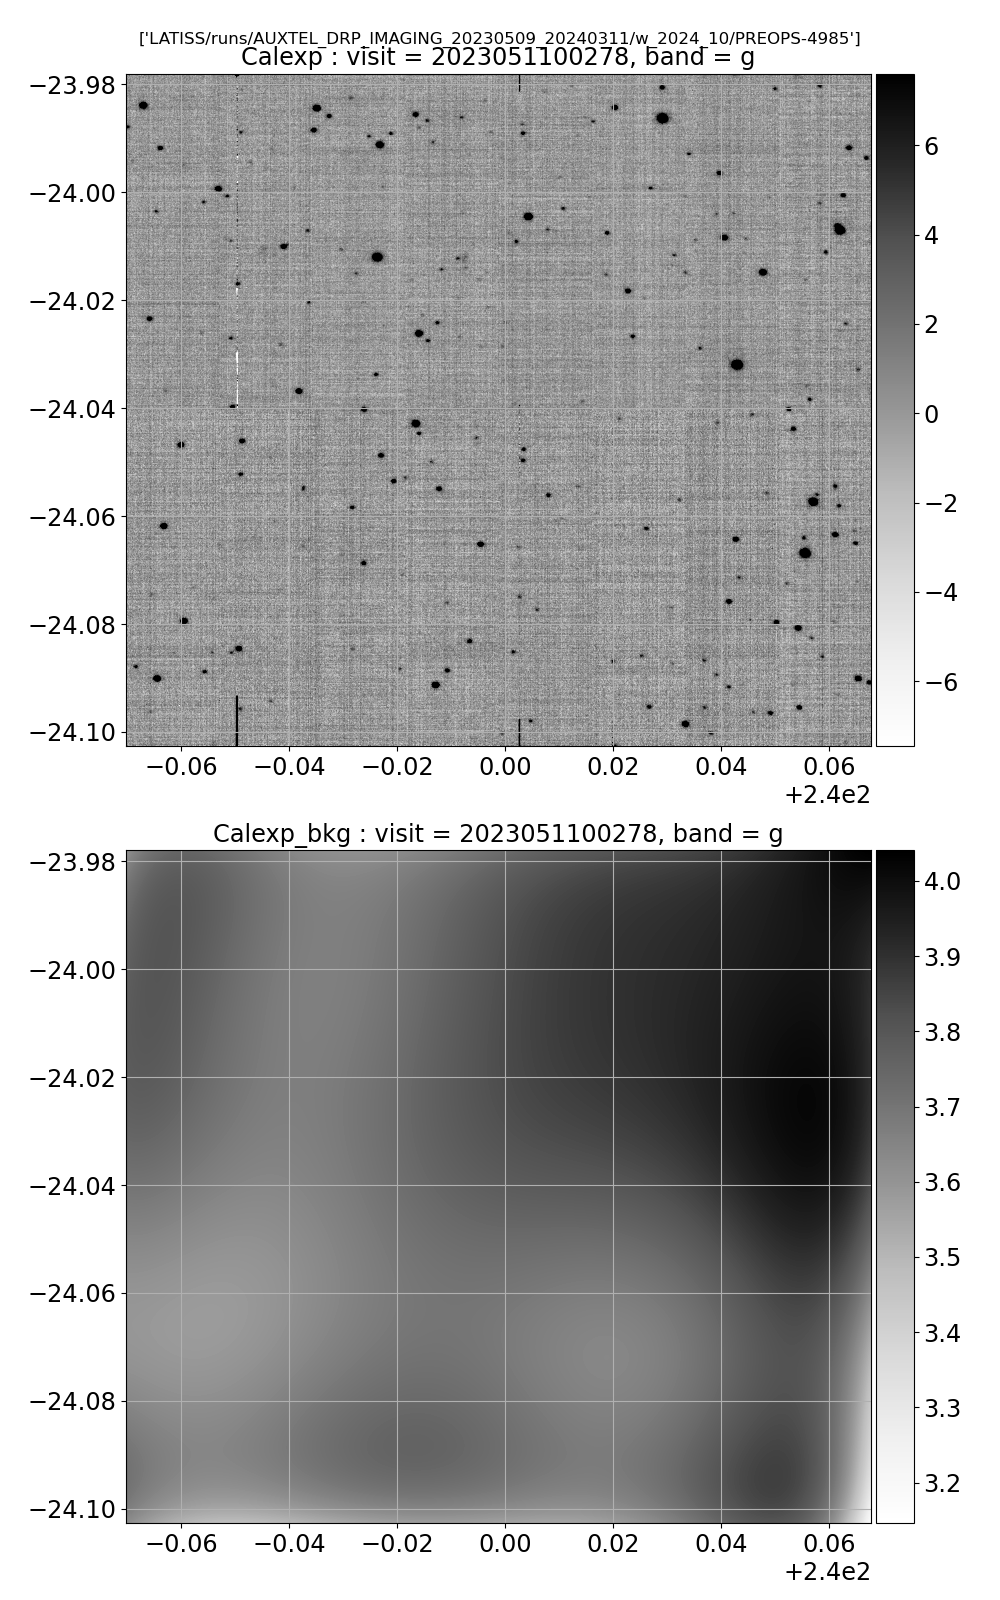

In [21]:
%matplotlib widget
img = butler.get("calexp", dataId=dataId, collections=collections)
bkgd = butler.get('calexpBackground', **dataId,collections=collections)

wcs = img.getWcs()
bbox = img.getBBox()
corners_ra, corners_dec = get_corners_radec(wcs, bbox)
extent = [np.min(corners_ra),np.max(corners_ra),np.min(corners_dec),np.max(corners_dec)]


# Display the image with a suitable scaling
med = np.median(img.image.array.flatten())
sigMad = 1.4826 * np.median(np.fabs(img.image.array.flatten() - med))
vmin = med - 1 * sigMad
vmax = med + 1 * sigMad

fig,axs = plt.subplots(2,1,figsize=(10,16))
ax = axs[0]
im=ax.imshow(img.image.array, origin="lower",vmin=vmin, vmax=vmax, cmap="Greys",extent=extent)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
the_title = f"Calexp : visit = {visitId}, band = {band}"
ax.set_title(the_title)
ax.grid()
ax.set_aspect('equal')
plt.colorbar(im, cax=cax,ax=ax)

ax2 = axs[1]
im2=ax2.imshow(bkgd.getImage().array, origin="lower", cmap="Greys",extent=extent)
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.05)
the_title2 = f"Calexp_bkg : visit = {visitId}, band = {band}"
ax2.set_title(the_title2)
ax2.grid()
ax2.set_aspect('equal')
plt.colorbar(im2, cax=cax2,ax=ax2)

plt.suptitle(collections)
plt.tight_layout()
plt.show()

In [22]:
calexp_metadata = dict(img.getMetadata())

In [23]:
calexp_metadata_keys= list(calexp_metadata.keys())
SELECTED_KEYS = ['CCDGAIN', 'CCDNOISE', 'LSST_NUM', 'FILTBAND','FILTER' , 'DATE', 'MJD', 'IMGTYPE', 'DATE-TRG', 'MJD-TRG', 'OBSID', 
                 'DATE-BEG', 'MJD-BEG', 'DATE-END', 'MJD-END', 'GROUPID', 'RA', 'DEC', 'RASTART', 'DECSTART', 'RAEND', 'DECEND', 'ROTPA', 'ROTCOORD', 'HASTART', 'ELSTART', 
                 'AZSTART', 'AMSTART','DAYOBS', 'SEQNUM',  'BGMEAN', 'BGVAR', 'SFM_ASTROM_OFFSET_MEAN', 'SFM_ASTROM_OFFSET_STD', 'MAGZERO', 'MAGZERO_RMS', 'MAGZERO_NOBJ']
for key in calexp_metadata_keys:
    if key in SELECTED_KEYS:
        print(key,calexp_metadata[key])

CCDGAIN 1.0
CCDNOISE 10.0
LSST_NUM ITL-3800C-068
DATE 2023-05-12T01:37:32.676
MJD 60076.0677393056
IMGTYPE OBJECT
DATE-TRG 2023-05-12T01:37:32.673
MJD-TRG 60076.0677392706
OBSID AT_O_20230511_000278
DATE-BEG 2023-05-12T01:37:02.437
MJD-BEG 60076.0673893173
DATE-END 2023-05-12T01:37:32.677
MJD-END 60076.0677393172
GROUPID 2023-05-12T01:33:18.296
RA 240.00083531625
DEC -24.0428666173583
RASTART 240.001011416711
DECSTART -24.0428604314063
RAEND 240.001069336247
DECEND -24.0428485911904
ROTPA 170.003015872044
ROTCOORD sky
HASTART -3.82812435463941
ELSTART 39.0811063213998
AZSTART 97.8018042947113
AMSTART 1.58248521168471
DAYOBS 20230511
SEQNUM 278
FILTBAND g
FILTER SDSSg_65mm
BGMEAN 3.82212735770911
BGVAR 0.0158389359422846
SFM_ASTROM_OFFSET_MEAN 0.0242425886820754
SFM_ASTROM_OFFSET_STD 0.0128575129682512
MAGZERO 24.2600199789393
MAGZERO_RMS 0.0019297690438897
MAGZERO_NOBJ 26


In [24]:
wcs = img.getWcs()
bbox = img.getBBox()
img.getPhotoCalib()

PhotoCalib(spatially constant with mean: 23.926 error: 0.0425257)

In [25]:
get_corners_radec(wcs, bbox)

([240.04624770069591,
  240.0679325126575,
  239.95137544919066,
  239.92978204398182],
 [-23.97801278822825,
  -24.08249920827296,
  -24.102637021353473,
  -23.99813423344754])

In [26]:
fitsMd = wcs.getFitsMetadata()
WCSfMd = WCS(fitsMd)

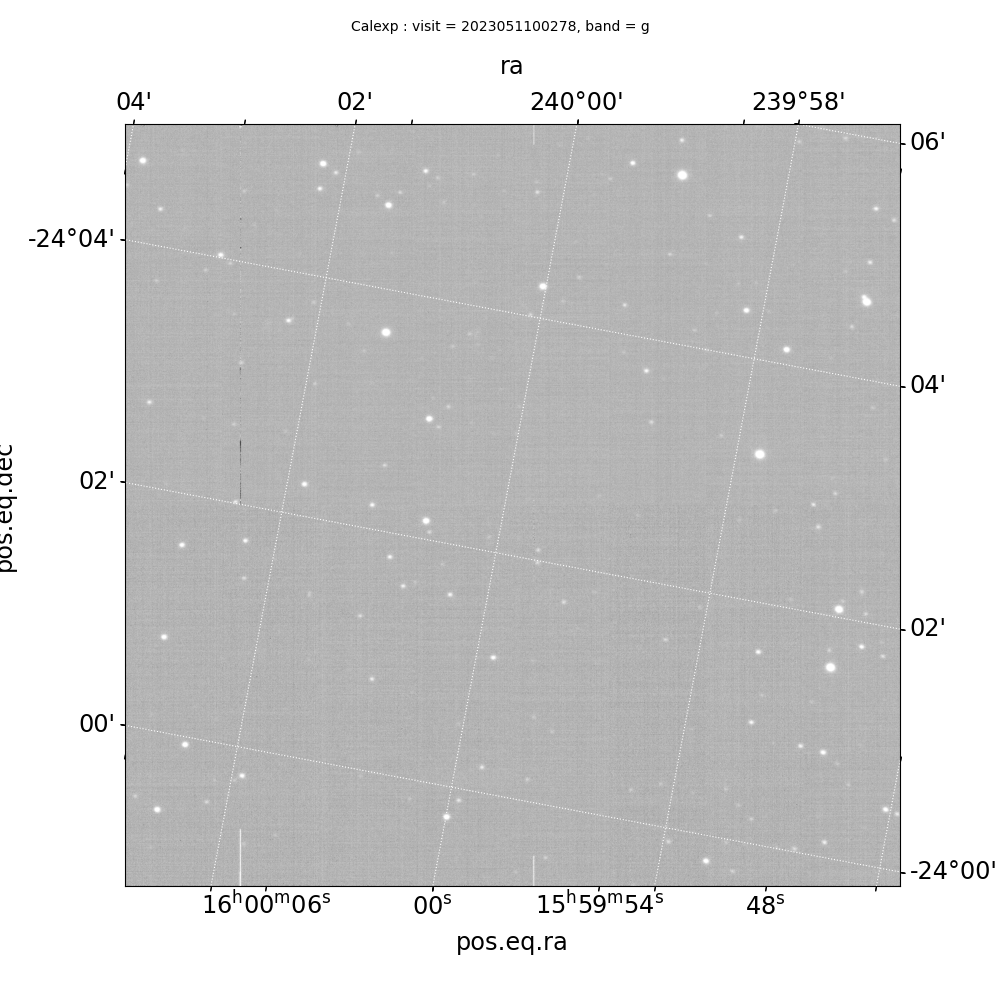

In [27]:
%matplotlib widget    
# Plot the calexp we just retrieved
plt.figure(figsize=(10,10))
plt.subplot(projection= WCSfMd)
    
transform = AsinhStretch() + ZScaleInterval()
scaledImage = transform(img.image.array)
    #scaledImage = np.flipud(scaledImage)
plt.imshow(scaledImage,origin="lower",aspect='equal',cmap="gray")
plt.suptitle(the_title,fontsize=10)

ax = plt.gca()
overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')
#plt.tight_layout()
plt.show()


## Footprints

https://pipelines.lsst.io/modules/lsst.afw.detection/Footprint.html

In [28]:
from lsst.meas.algorithms.detection import SourceDetectionTask
sourceDetectionTask = SourceDetectionTask(schema=schema)
result = sourceDetectionTask.run(tab, img)

In [29]:
# Grab the above-threshold footprints that were detected,
#  and assign them to the variable `fps`
fpset = result.positive
fps = fpset.getFootprints()

In [30]:
len(fps)

159

In [31]:
#initial_psf_stars_footprints = butler.get("initial_stars_footprints_detector", dataId=dataId, collections=collections)
#[DatasetType('initial_psf_stars_footprints', {band, instrument, detector, physical_filter, visit}, SourceCatalog),
# DatasetType('initial_stars_footprints_detector', {band, instrument, detector, physical_filter, visit}, SourceCatalog),
# DatasetType('initial_psf_stars_footprints_detector', {band, instrument, detector, physical_filter, visit}, SourceCatalog)]

In [32]:
fps[:10]

[5 peaks, area=20334, centroid=(606.844, 161.927),
 4 peaks, area=13430, centroid=(2162.77, 106.501),
 1 peaks, area=3970, centroid=(3192.67, 76.5695),
 1 peaks, area=2341, centroid=(2052.96, 73.8103),
 1 peaks, area=6853, centroid=(3054.48, 130.621),
 1 peaks, area=4608, centroid=(3516.69, 195.624),
 1 peaks, area=2243, centroid=(3424.2, 200.953),
 1 peaks, area=1458, centroid=(132.24, 204),
 1 peaks, area=5016, centroid=(3674.17, 228.364),
 1 peaks, area=3400, centroid=(3158.09, 228.715)]

In [33]:
idx_fps = 0
the_fps = fps[idx_fps]
fps_centroid = the_fps.getCentroid()
fps_peaks = the_fps.getPeaks()
fps_npeaks = len(fps_peaks)
fps_area = the_fps.getArea()

In [34]:
fps_peaks

<class 'lsst.afw.detection.PeakCatalog'>
 id  f_x   f_y  i_x i_y peakValue    significance   
     pix   pix  pix pix     ct                      
--- ----- ----- --- --- --------- ------------------
293 605.0  61.0 605  61 12.214105 28.332651138305664
294 606.0 114.0 606 114  8.694289  20.48993492126465
297 606.0 268.0 606 268  8.371254  20.34977149963379
295 606.0 157.0 606 157  8.353578 19.823627471923828
296 607.0 214.0 607 214  8.287395    19.777099609375

In [35]:
fps_centroid[0] 

606.8443493655946

In [36]:
# We can get a rough view of the first source's footprint from its span
#fps[0].getSpans()
fps[idx_fps].isHeavy()

False

In [37]:
# Next, we make all the footprints heavy at the same time
#  by operating on the footprint set
fpset.makeHeavy(img.getMaskedImage())

# This means we have to redefine fps:
hfps = fpset.getFootprints()

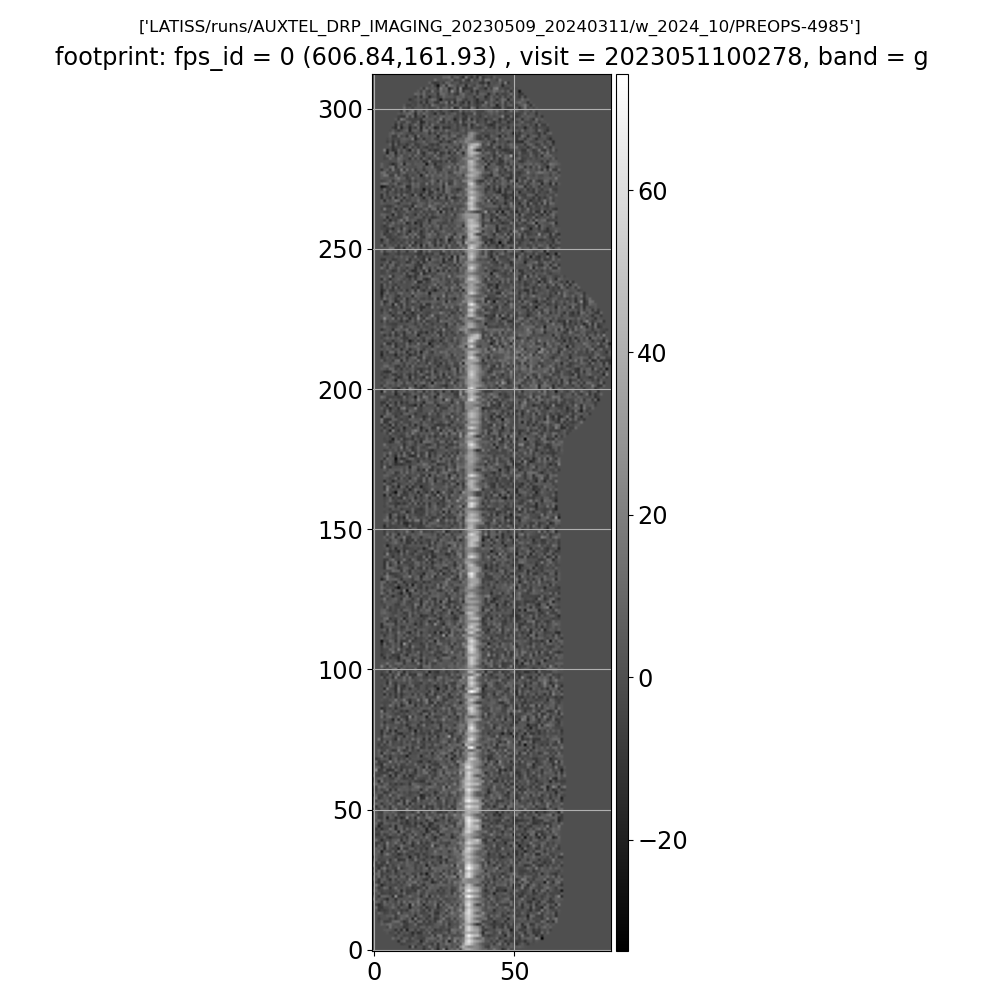

In [38]:
%matplotlib widget
fig,ax = plt.subplots(1,1,figsize=(10,10))
im = ax.imshow(fps[idx_fps].getSpans().unflatten(hfps[idx_fps].getImageArray()),cmap='gray', origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
the_title = f"footprint: fps_id = {idx_fps} ({fps_centroid[0]:.2f},{fps_centroid[1]:.2f}) , visit = {visitId}, band = {band}"
ax.set_title(the_title)
ax.grid()
ax.set_aspect('equal')
plt.colorbar(im, cax=cax)
plt.suptitle(collections)
plt.tight_layout()

### Choose the region with no star

In [39]:
ra0 = 122.54952
dec0 = -36.16994

In [40]:
ra0_deg = geom.Angle(ra0,geom.degrees)
dec0_deg = geom.Angle(dec0,geom.degrees)

In [41]:
spt = geom.SpherePoint(longitude = ra0_deg,latitude= dec0_deg)

In [42]:
pt = wcs.skyToPixel(spt)

In [43]:
pt[0]

nan

In [44]:
xmin= pt[0]
ymin=pt[1]
width = 100
height= 100
extent = [xmin,xmin+width,ymin,ymin+height]

ramin,decmin = wcs.pixelToSky(x=float(xmin), y=float(ymin))
ramax,decmax = wcs.pixelToSky(x=float(xmin+width), y=float(ymin+height))

# Define a small region for a cutout
bbox = geom.Box2I()
bbox.include(geom.Point2I(xmin, ymin))
bbox.include(geom.Point2I(xmin + width, ymin + height))

# An alternative way to defined the same cutout region
# bbox = geom.Box2I(geom.Point2I(xmin, ymin), geom.Extent2I(width, height))

# Generate the cutout image
cutout = img.Factory(img, bbox, origin=afwImage.LOCAL, deep=False)

LengthError: 
  File "src/image/Image.cc", line 70, in static lsst::afw::image::ImageBase<PixelT>::_view_t lsst::afw::image::ImageBase<PixelT>::_makeSubView(const lsst::geom::Extent2I&, const lsst::geom::Extent2I&, const _view_t&) [with PixelT = float; _view_t = boost::gil::image_view<boost::gil::memory_based_2d_locator<boost::gil::memory_based_step_iterator<boost::gil::pixel<float, boost::gil::layout<boost::mp11::mp_list<boost::gil::gray_color_t> > >*> > >; lsst::geom::Extent2I = lsst::geom::Extent<int, 2>]
    Box2I(Point2I(-2147483648,-2147483648),lsst::geom::Extent2I(1,1)) doesn't fit in image 4072x4000 {0}
lsst::pex::exceptions::LengthError: 'Box2I(Point2I(-2147483648,-2147483648),lsst::geom::Extent2I(1,1)) doesn't fit in image 4072x4000'


In [ ]:
ramin,decmin,ramax,decmax

In [ ]:
ra0 = (ramin+ramax)/2
dec0 = (decmin+decmax)/2

In [ ]:
%matplotlib widget
# Display the cutout and sources with afw display
image = cutout.image
fig,ax = plt.subplots(1,1,figsize=(8,8))
#im=ax.imshow(image.array, origin="lower",vmin=vmin, vmax=vmax, extent=extent ,cmap="gray")
im=ax.imshow(image.array, origin="lower", extent=extent ,cmap="gray")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
the_title = f"Calexp cutout visit = {visitId}, band = {band}"
ax.set_title(the_title)
ax.grid()
plt.colorbar(im, cax=cax)
plt.suptitle(collections)
plt.tight_layout()
plt.show()

## Many cutout on several visits
https://pipelines.lsst.io/py-api/lsst.geom.Angle.html

In [ ]:
nRow = 10
nCol = 5 
nIMG = nRow*nCol 

In [ ]:
spt

In [ ]:
fig, axes = plt.subplots(nRow, nCol, figsize=(3*nCol, 3*nRow), constrained_layout=True)

idxvisitToPlot = 0


for idx, ax in enumerate(axes.flat):
    if idx >= nIMG:
        break
    if idxvisitToPlot>= len(my_selectedvisits):
        break

    FlagPlot = False
    while not  FlagPlot:
        visitId = my_selectedvisits[idxvisitToPlot]
        dataId = {'visit': visitId, 'instrument':instrument_sel , 'detector': 0}

        # call butler
        exp = butler.get("calexp", dataId=dataId, collections=collections)
        wcs = exp.getWcs()
        bbox = exp.getBBox()

        # must test if the calexp include the selected point
        corners_ra, corners_dec = get_corners_radec(wcs, bbox)
        
        # 2D point
        pt = wcs.skyToPixel(spt)

        xmin= pt[0]
        ymin=pt[1]
        width = 100
        height= 100
        extent = [xmin,xmin+width,ymin,ymin+height]

        ramin,decmin = wcs.pixelToSky(x=float(xmin), y=float(ymin))
        ramax,decmax = wcs.pixelToSky(x=float(xmin+width), y=float(ymin+height))
        dra = ramax-ramin
        ddec = decmax-decmin
        #asDegrees()
        
        dracosdecddec = np.cos(ddec.asRadians())*dra.asArcseconds()*ddec.asArcseconds() 
        print("dra=",dra,"  ddec=",ddec, "    dracosdecddec=" ,dracosdecddec, " arcsec2")

        # Define a small region for a cutout
        bbox = geom.Box2I()
        bbox.include(geom.Point2I(xmin, ymin))
        bbox.include(geom.Point2I(xmin + width, ymin + height))

        # An alternative way to defined the same cutout region
        # bbox = geom.Box2I(geom.Point2I(xmin, ymin), geom.Extent2I(width, height))

    
        try:
        # Generate the cutout image
            cutout = exp.Factory(exp, bbox, origin=afwImage.LOCAL, deep=False)
            
            med = np.median(cutout.image.array.flatten())
            sigMad = 1.4826 * np.median(np.fabs(cutout.image.array.flatten() - med))
            
            #print(f"{idx} :: {visitId}  med= {med:.3f} sigMad = {sigMad:.3f}")

            im=ax.imshow(cutout.image.array, origin="lower", vmin=vmin,vmax=vmax, extent=extent ,cmap="gray")
            #divider = make_axes_locatable(ax)
            #cax = divider.append_axes("right", size="5%", pad=0.05)
            the_title = f"visit = {visitId}"
            ax.set_title(the_title)
            ax.grid()
            #plt.colorbar(im, cax=cax,ax=ax)
            FlagPlot = True

        except Exception as inst:

            print(type(inst))    # the exception type
            #print(inst.args)     # arguments stored in .args
            #print(inst)          # __str__ allows args to be printed directly,

        # always increase
        idxvisitToPlot +=1        

plt.tight_layout()
plt.show()
    

In [ ]:
spt

In [ ]:
Background_Dict = OrderedDict()

for idxvisit in range(len(my_selectedvisits)):
    
    visitId = my_selectedvisits[idxvisit]
    dataId = {'visit': visitId, 'instrument':instrument_sel , 'detector': 0}

    print(dataId)

    # call butler
    exp = butler.get("calexp", dataId=dataId, collections=collections)
    wcs = exp.getWcs()
    bbox = exp.getBBox()

    # must test if the calexp include the selected point
    corners_ra, corners_dec = get_corners_radec(wcs, bbox)
    # 2D point
    pt = wcs.skyToPixel(spt)

    xmin= pt[0]
    ymin=pt[1]
    width = 100
    height= 100
    extent = [xmin,xmin+width,ymin,ymin+height]

    ramin,decmin = wcs.pixelToSky(x=float(xmin), y=float(ymin))
    ramax,decmax = wcs.pixelToSky(x=float(xmin+width), y=float(ymin+height))
    dra = ramax-ramin
    ddec = decmax-decmin    
    dracosdecddec = np.cos(ddec.asRadians())*dra.asArcseconds()*ddec.asArcseconds() 

    # Define a small region for a cutout
    bbox = geom.Box2I()
    bbox.include(geom.Point2I(xmin, ymin))
    bbox.include(geom.Point2I(xmin + width, ymin + height))

    # An alternative way to defined the same cutout region
    # bbox = geom.Box2I(geom.Point2I(xmin, ymin), geom.Extent2I(width, height))

    
    try:
    # Generate the cutout image
        cutout = exp.Factory(exp, bbox, origin=afwImage.LOCAL, deep=False)
        # njansky    
        med = np.median(cutout.image.array.flatten())
        sigMad = 1.4826 * np.median(np.fabs(cutout.image.array.flatten() - med))
        skyBgFlux_perarcsec2 = sigMad/dracosdecddec
        skyBgMag_perarcsec2 =  convert_fluxtomag(skyBgFlux_perarcsec2)
            
        Background_Dict[visitId] = dict(med=med,sigMad=sigMad,skybgflx=skyBgFlux_perarcsec2,skybgmag = skyBgMag_perarcsec2  )  
        print(f"{idxvisit} :: {visitId}  med= {med:.3f} sigMad = {sigMad:.3f} skybgmag = {skyBgMag_perarcsec2:.3f} ")

    except Exception as inst:

        print(type(inst))    # the exception type
        #print(inst.args)     # arguments stored in .args
        #print(inst)          # __str__ allows args to be printed directly,
        pass

In [ ]:
Background_Dict

In [ ]:
X = []
Y1 = []
EY1 = []
Y2 = []
for visitId in Background_Dict.keys():
    cut = df_myselectedvisits["visitId"] == visitId
    mjd = df_myselectedvisits[cut]['expMidptMJD'].values[0]
    X.append(mjd)
    Y1.append(Background_Dict[visitId]['med'])
    EY1.append(Background_Dict[visitId]['sigMad'])
    Y2.append(Background_Dict[visitId]['skybgmag'])
    

In [ ]:
X = np.array(X)
Y1 = np.array(Y1)
EY1 = np.array(EY1)
Y2 = np.array(Y2)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.errorbar(X,Y1,yerr=EY1,marker="o",mfc="red",mec="grey",ms=10)
ax.grid()
ax.set_title(f"Sky Background in band {band}")
ax.set_xlabel("MJD")
ax.set_ylabel("Flux (nJy)")
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(X,Y2,marker="o",mfc="red",mec="grey",ms=10)
ax.grid()
ax.set_title(f"Sky Background in band {band}")
ax.set_xlabel("MJD")
ax.set_ylabel("Mag Flux (mag/arcsec2)")
plt.show()

In [ ]:
assert False

In [ ]:
fig, axes = plt.subplots(nRow, nCol, figsize=(3*nCol, 3*nRow), constrained_layout=True)
list_of_axes = axes.flat
idx = 0

while idx < nIMG:
    visitId = my_selectedvisits[idx]
    dataId = {'visit': visitId, 'instrument':instrument_sel , 'detector': 0}

    # call butler
    exp = butler.get("calexp", dataId=dataId, collections=collections)
    wcs = exp.getWcs()
    bbox = exp.getBBox()

    # must test if the calexp include the selected point
    corners_ra, corners_dec = get_corners_radec(wcs, bbox)
    # 2D point in pixels
    pt = wcs.skyToPixel(spt)

    xmin= pt[0]
    ymin=pt[1]
    width = 100
    height= 100
    extent = [xmin,xmin+width,ymin,ymin+height]

    ramin,decmin = wcs.pixelToSky(x=float(xmin), y=float(ymin))
    ramax,decmax = wcs.pixelToSky(x=float(xmin+width), y=float(ymin+height))

    # Define a small region for a cutout
    bbox = geom.Box2I()
    bbox.include(geom.Point2I(xmin, ymin))
    bbox.include(geom.Point2I(xmin + width, ymin + height))

    # An alternative way to defined the same cutout region
    # bbox = geom.Box2I(geom.Point2I(xmin, ymin), geom.Extent2I(width, height))

    try:
    # Generate the cutout image     
        cutout = exp.Factory(exp, bbox, origin=afwImage.LOCAL, deep=False)
        print(idx,visitId)
        ax = list_of_axes[idx] 

        im=ax.imshow(cutout.image.array, origin="lower", extent=extent ,cmap="gray")
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        the_title = f"visit = {visitId}, f = {band}"
        ax.set_title(the_title)
        ax.grid()
        plt.colorbar(im, cax=cax,ax=ax)
        idx = idx + 1
    except Exception as inst:
        print(type(inst))    # the exception type
        #print(inst.args)     # arguments stored in .args
        #print(inst)          # __str__ allows args to be printed directly,

        

plt.tight_layout()
    

In [ ]:
assert False

In [ ]:
# Plot cutouts centered on matched sources from different visits for a couple of objects.
# Selecting from the small/largeStdLists made above to look at the extremes.
imMin, imMax, Q = -0.001, 0.004, 8
expMin, expMax = -25, 100
numSub = 8
for maxBoxSize in [71]:
    plt.close("all")
    for objInd in smallStdList[0:3] + largeStdList[1:2]:
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        numObj = len(joinedObjects)
        print("numObj = {} [with obj_index = {}]".format(numObj, objInd))
        nRow = 1 if numObj <= numSub else (numObj // numSub) + 1
        # print("nRow = {}".format(nRow))
        fig, axes = plt.subplots(nRow, numSub, figsize=(3*numSub, 3*nRow), constrained_layout=True)
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        
        psfMag = joinedObjects["psfMag"]
        psfMagErr = joinedObjects["psfMagErr"]
        psfMagDiffMmag = joinedObjects["psfMagDiffMmag"].values
        psfMagStdMmag = psfMagStdMmagDict[objInd]

        clippedMeanRaArray = scipy.stats.sigmaclip(joinedObjects["ra"], low=3.0, high=3.0).clipped
        clippedMeanRa = np.mean(clippedMeanRaArray)
        clippedMeanDecArray = scipy.stats.sigmaclip(joinedObjects["dec"], low=3.0, high=3.0).clipped
        clippedMeanDec = np.mean(clippedMeanDecArray)

        iObj = -1
        for ax in axes.ravel():
            iObj += 1
            if iObj < numObj:
                row = joinedObjects[iObj:iObj + 1]
                detector = row["detector"].values[0]
                visit = row["visit"].values[0]
                psfMag = (row["psfFlux"].values[0]*u.nJy).to(u.ABmag)

                dataId = {"detector": detector, "visit": visit}
                exp = butler.get("calexp", dataId)
                wcs = exp.wcs
                pt = geom.SpherePoint(geom.Angle(row["ra"].values[0], geom.degrees),
                                      geom.Angle(row["dec"].values[0], geom.degrees))
                (xSrc, ySrc) = wcs.skyToPixel(pt)

                boxSize = int(min(maxBoxSize, xSrc, exp.getWidth()-xSrc, ySrc, exp.getHeight()-ySrc) - 1)

                minBbox = geom.Point2I(int(xSrc) - boxSize ,int(ySrc) - boxSize)
                maxBbox = geom.Point2I(int(xSrc) + boxSize, int(ySrc) + boxSize)
                srcBbox = geom.Box2I(minBbox, maxBbox)

                subimg = afwImage.ExposureF(exp, srcBbox, afwImage.PARENT, True)
                subimgRgb = afwRgb.makeRGB(subimg.image.array, None, None, expMin, expMax - expMin, Q)

                im = ax.imshow(subimgRgb, interpolation="nearest", origin="lower")
                ax.text(0.5, 0.06, "psfSig: {:.2f} pix".format(row["psfSigma"].values[0]),
                        color="cyan", fontsize=14, ha="center", va="center", transform=ax.transAxes)
                ax.text(0.5, 0.15, "{:.2f}".format(psfMag),
                        color="violet", fontsize=14, ha="center", va="center", transform=ax.transAxes)

                diffColor = "red" if np.abs(psfMagDiffMmag[iObj]) > 100 else "lawngreen"
                ax.text(0.5, 0.92, "diff: {:.2f} mmag".format(psfMagDiffMmag[iObj]),
                        color=diffColor, fontsize=14, ha="center", va="center", transform=ax.transAxes)

                ax.set_title("{} {}sec".format(visit, row["expTime"].values[0]), fontsize=12)

        color = "green"
        plt.text(0.5, 0.84, "std: {:.2f} mmag".format(psfMagStdMmag), color=color, fontsize=14,
                 ha="center", va="center", transform=ax.transAxes)

        if doSaveFigs:
            filename = "{}{}_allOjbectsSmallStd_{}_{}_{}".format(saveDir, camera.getName(), objInd, maxBoxSize, collectionStr)
            print("Saving file in: {}".format(filename))
            plt.savefig(filename, dpi=250)